# Adatelemzés

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [3]:
products = pd.read_csv("products.csv", delimiter=";")
customers = pd.read_csv("customers.csv", delimiter=";")
orders = pd.read_csv("orders.csv", delimiter=";")
sales = pd.read_csv("sales.csv", delimiter=";")

## EDA - Hiányzó értékek és outlierek

Products missing values:
product_ID      0
product_type    0
product_name    0
size            0
colour          0
price           0
quantity        0
description     0
dtype: int64

Customers missing values:
customer_id      0
customer_name    0
gender           0
age              0
home_address     0
zip_code         0
city             0
state            0
country          0
dtype: int64

Orders missing values:
order_id         0
customer_id      0
payment          0
order_date       0
delivery_date    0
dtype: int64

Sales missing values:
sales_id          0
order_id          0
product_id        0
price_per_unit    0
quantity          0
total_price       0
dtype: int64



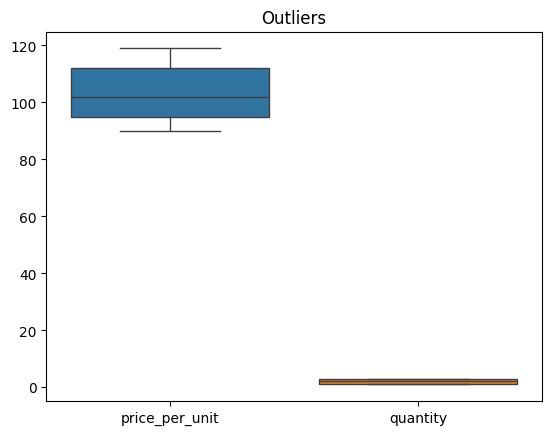

In [5]:
for df, name in zip([products, customers, orders, sales], ['Products', 'Customers', 'Orders', 'Sales']):
    print(f"{name} missing values:\n{df.isnull().sum()}\n")

sns.boxplot(data=sales[['price_per_unit', 'quantity']])
plt.title('Outliers')
plt.show()

## Aggregálás havi, heti, napi szinten

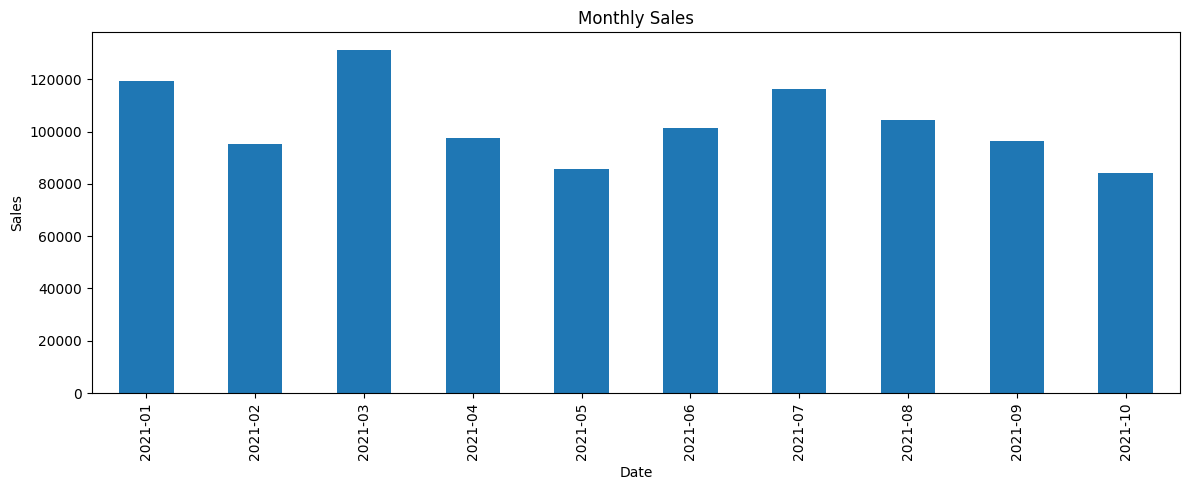

In [48]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
sales_orders = pd.merge(sales, orders, on='order_id')
monthly_sales = sales_orders.groupby(sales_orders['order_date'].dt.to_period('M'))['total_price'].sum()
monthly_sales.plot(kind='bar', figsize=(12, 5), title="Monthly Sales")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

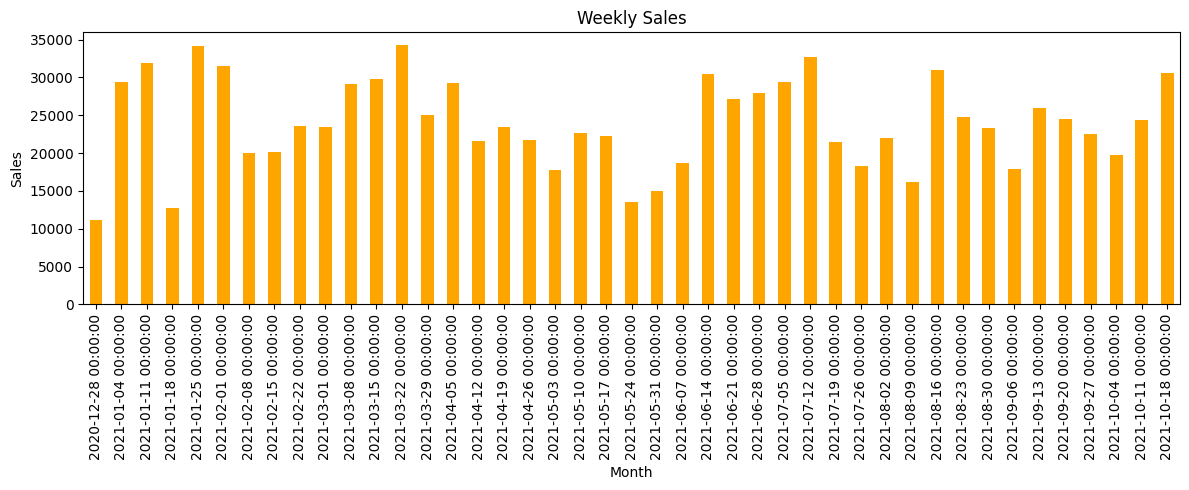

In [46]:
weekly_sales = sales_orders.groupby(sales_orders['order_date'].dt.to_period('W'))['total_price'].sum()
weekly_sales.index = weekly_sales.index.to_timestamp()
weekly_sales.plot(kind='bar', figsize=(12, 5), title="Weekly Sales", color='orange')
plt.ylabel("Sales")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

In [64]:
month = '2021-9'

<ipython-input-65-801829c05c6d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_sales_month.index, y=daily_sales_month.values, palette='crest')


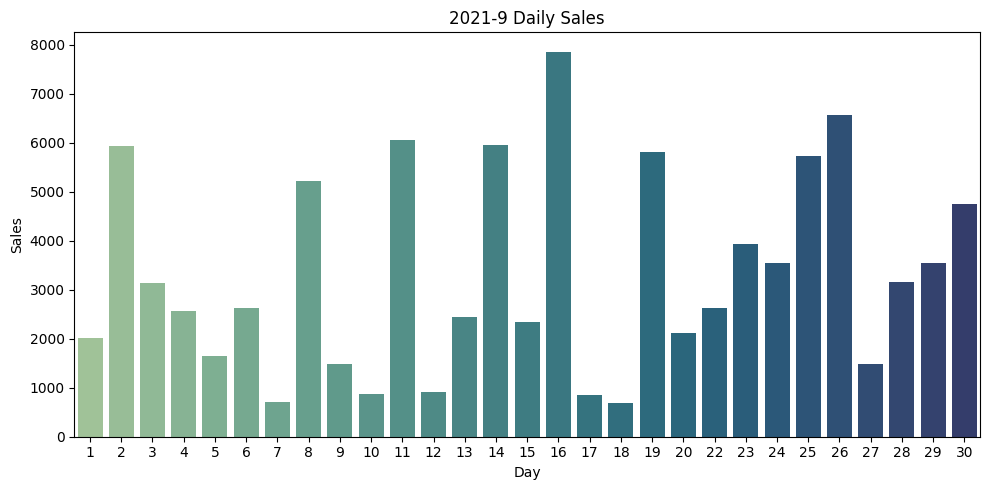

In [65]:
sales_orders['order_date'] = pd.to_datetime(sales_orders['order_date'])
chosen_month = sales_orders[sales_orders['order_date'].dt.to_period('M') == month]
daily_sales_month = chosen_month.groupby(sales_orders['order_date'].dt.day)['total_price'].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=daily_sales_month.index, y=daily_sales_month.values, palette='crest')
plt.title(f"{month} Daily Sales")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

## Vásárlási szokások

<ipython-input-57-f5f14f93dd93>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_sales, x='gender', y='total_price', palette='pastel')


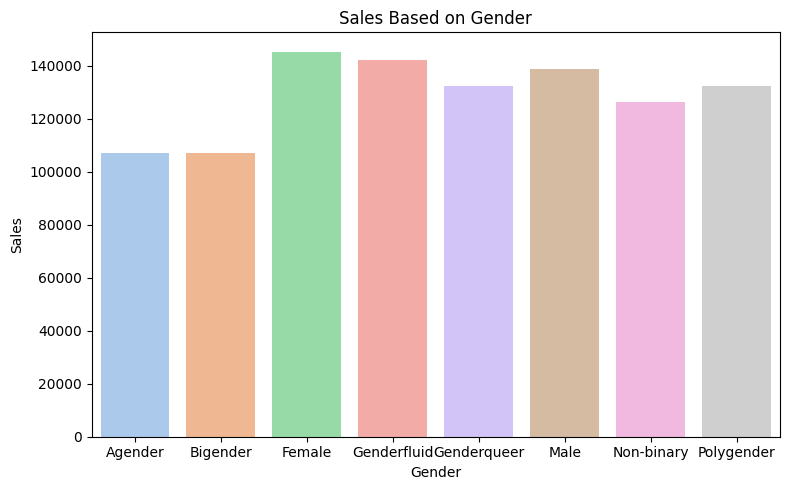

In [57]:
sales_customers = sales_orders.merge(customers, on='customer_id')
gender_sales = sales_customers.groupby('gender')['total_price'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=gender_sales, x='gender', y='total_price', palette='pastel')
plt.title("Sales Based on Gender")
plt.xlabel("Gender")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

<ipython-input-56-5a05c1f58a8f>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_sales = sales_customers.groupby('age_group')['total_price'].sum().reset_index()
<ipython-input-56-5a05c1f58a8f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_sales, x='age_group', y='total_price', palette='Blues')


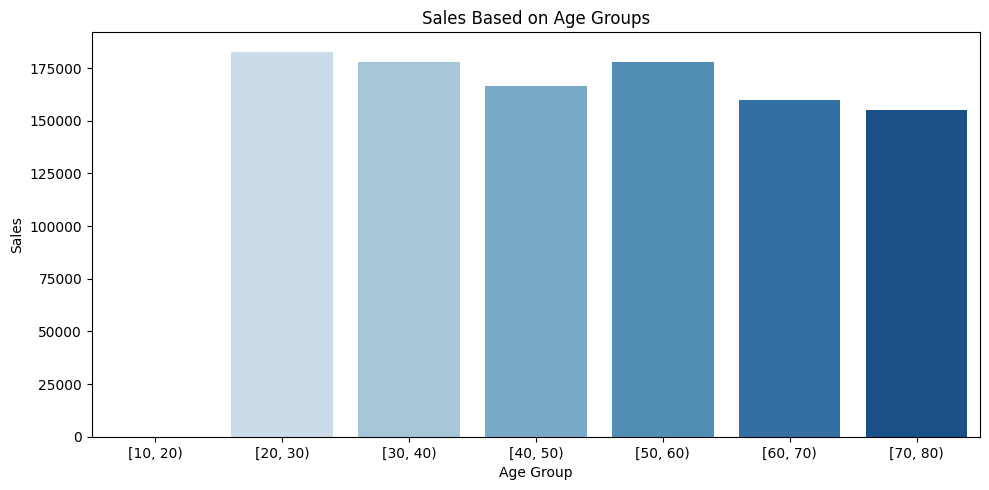

In [56]:
sales_customers['age_group'] = pd.cut(sales_customers['age'], bins=range(10, 81, 10), right=False)

age_sales = sales_customers.groupby('age_group')['total_price'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=age_sales, x='age_group', y='total_price', palette='Blues')
plt.title("Sales Based on Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

<ipython-input-55-2ec82fc38e4d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_sales, x='state', y='total_price', palette='Greens')


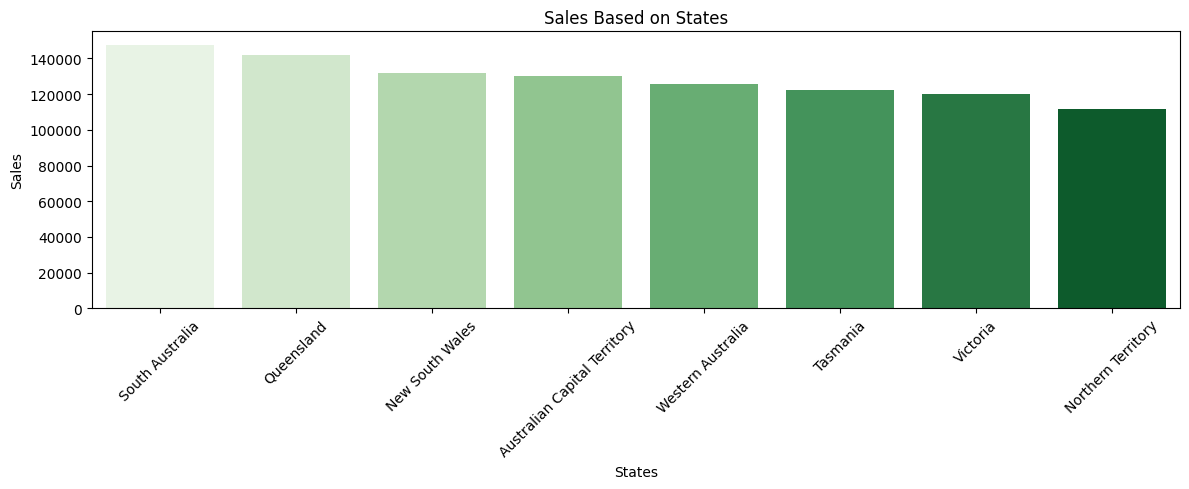

In [55]:
state_sales = sales_customers.groupby('state')['total_price'].sum().reset_index().sort_values(by='total_price', ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(data=state_sales, x='state', y='total_price', palette='Greens')
plt.title("Sales Based on States")
plt.xlabel("States")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Legkelendőbb termékek

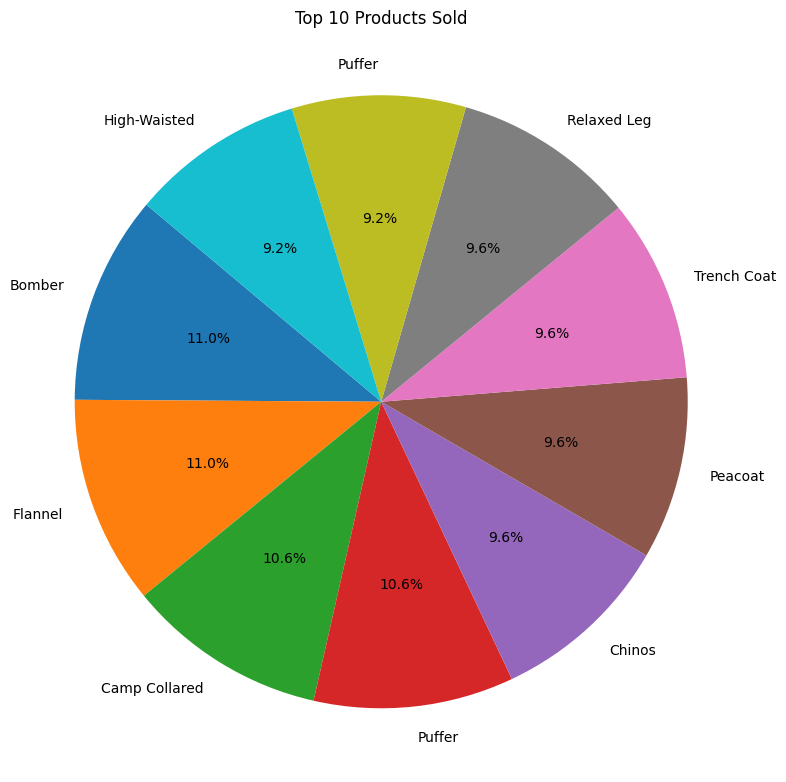

In [17]:
top_products = sales.groupby('product_id', as_index=False)['quantity'].sum()
top_products = top_products.rename(columns={'quantity': 'quantity_sold'})

merged = top_products.merge(products, left_on='product_id', right_on='product_ID', how='left')
merged = merged.sort_values(by='quantity_sold', ascending=False).head(10)

plt.figure(figsize=(8, 8))
plt.pie(merged['quantity_sold'], labels=merged['product_name'], autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Products")
plt.axis('equal')
plt.tight_layout()
plt.show()

## Időszakos eladási minták

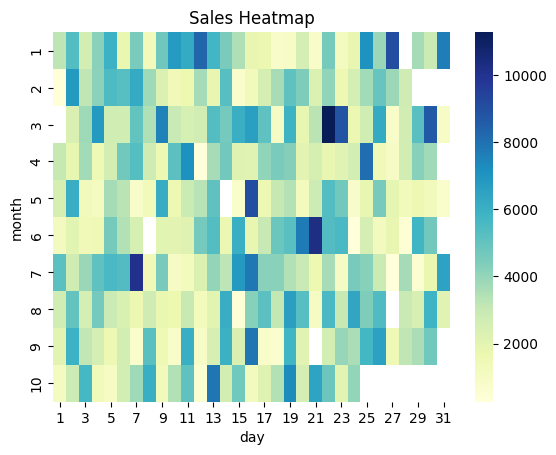

In [59]:
sales_orders['day'] = sales_orders['order_date'].dt.day
sales_orders['month'] = sales_orders['order_date'].dt.month

heat_data = sales_orders.groupby(['month', 'day'])['total_price'].sum().unstack()
sns.heatmap(heat_data, cmap="YlGnBu")
plt.title("Sales Heatmap")
plt.show()

## Vásárlási trendek

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0828
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0372
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0376
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0384
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0372
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0310
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0348
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0398
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0330
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0323
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0358
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0391
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0337
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0411
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0373
Epoch 16/20
17/

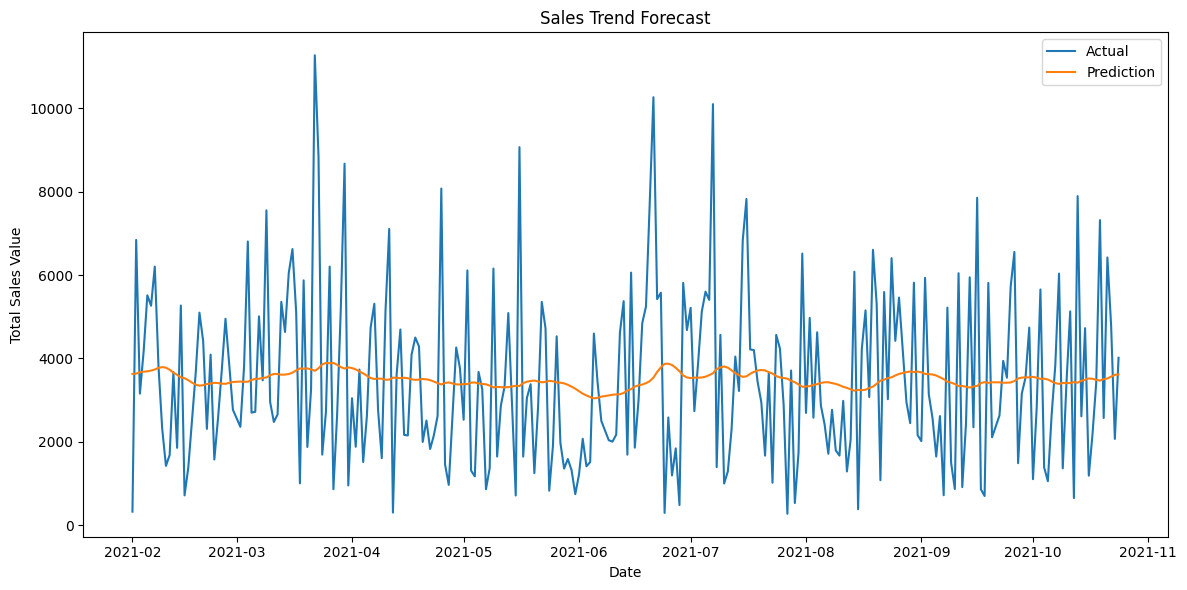

In [63]:
daily_sales = sales_orders.groupby('order_date')['total_price'].sum().reset_index()
daily_sales = daily_sales.set_index('order_date')

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_sales)

sequence_length = 30
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=16, verbose=1)

predicted = model.predict(X)
predicted = scaler.inverse_transform(predicted)
real = scaler.inverse_transform(y.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index[sequence_length:], real, label='Actual')
plt.plot(daily_sales.index[sequence_length:], predicted, label='Prediction')
plt.title("Sales Trend Forecast")
plt.xlabel("Date")
plt.ylabel("Total Sales Value")
plt.legend()
plt.tight_layout()
plt.show()